In [ ]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
load_dotenv()

model = ChatOpenAI(model="gpt-4o-mini")


In [ ]:
pip install python-dotenv langchain langgraph langchain-community langchain-experimental langchain-openai

In [ ]:
from typing_extensions import TypedDict

class MyState(TypedDict):
    message: str
    a: str
    b: str

In [ ]:
from langchain_core.runnables import RunnableLambda

def function_1(state: MyState) -> MyState:
    print("Function 1 received:", state)

    return {'a' : state['message'] + " from function 1"}

def function_2(state: MyState) -> MyState:
    print("Function 2 received:", state)

    return {'b' : state['a'] + " from function 2"}
  

In [ ]:
from langgraph.graph import StateGraph

workflow = StateGraph(MyState)

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)
workflow.add_edge("node_1", "node_2")

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

graph= workflow.compile()
graph

In [ ]:
response= graph.invoke({'message': "Hello"})
response

In [ ]:
for output in graph.stream({'message': "Hello"}):
     for key, value in output.items():
         print(f"{key}: {value}")

In [ ]:
import operator
from langgraph.graph.message import  add_messages
from langchain.messages import HumanMessage,AIMessage, RemoveMessage


messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Siva", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Siva", id="4"))

messages_tobe_deleted= [RemoveMessage(id=2), RemoveMessage(id=4)]

add_messages(messages,messages_tobe_deleted)





In [ ]:
from typing import Annotated
import operator

class MyState(TypedDict):
    messages:   Annotated[list,add_messages]
   


def function_1(state: MyState) -> MyState:

    response = model.invoke(state['messages'])
    
    return {"messages": [response]}

def function_2(state):
   # print("Function 2 called with input:", state)
    return  state

In [ ]:
workflow = StateGraph(MyState)
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)
workflow.add_edge("node_1", "node_2")
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")
graph= workflow.compile()
graph

In [ ]:
from langchain.messages import HumanMessage,AIMessage

result= graph.invoke({
    'messages': [
       HumanMessage(content="Hello, how are you?"),
        HumanMessage(content="Hello, how are you?"),
    ]
})

result

In [ ]:
result['messages']

In [ ]:
pip install pyowm

In [ ]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper

weather = OpenWeatherMapAPIWrapper()
weather.run("Bangalore")

In [ ]:
class OverallState(TypedDict):
    query: str    
    response: str

class MyPrivateState(TypedDict):
    city: str

class InputState(TypedDict):
    query: str

class OutputState(TypedDict):
    response: str

class MyContext(TypedDict):
    username: str


def function_1(state:InputState) -> MyPrivateState:
    prompt = "Your task is to provide only city name based on the query. " \
             "Just return the city name without any additional text. Following is the query: " + state['query']
    #print("Context username:", context['username'])
    response = model.invoke(prompt)
    
    return {"city": response.content}

def function_2(state:MyPrivateState) -> OverallState:

    response = weather.run(state['city'])
    return {"response": response}


def function_3(state:OverallState) -> OutputState:
    agent2_query = """Your task is to provide info concisely based on the
             user query and the available information from the internet.
            Following is the user query: """ + state['query'] + " Available information: " + state['response']
    
    
    response = model.invoke(agent2_query)
    return {"response": response.content}

In [ ]:
workflow = StateGraph(state_schema=OverallState,input_schema=InputState,output_schema=OutputState, )

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)
workflow.add_node("node_3", function_3)
workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_2", "node_3")
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_3")
graph= workflow.compile()
graph


In [ ]:
graph.invoke({'query': "What's the humidity like in Bangalore today?"})

In [ ]:
pip install langchain-tavily

In [ ]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch()
tavily_search.invoke("Tell me about Sivaprasad valluru")

In [ ]:
model= ChatOpenAI(model="gpt-4.1-mini")
model_withtools= model.bind_tools([tavily_search])

result= model_withtools.invoke("Tell me about Sivaprasad valluru")
result

In [ ]:
result.tool_calls

In [ ]:
class MyState(TypedDict):
    messages: Annotated[list,add_messages]

In [ ]:
def function_1(state):
    messages = state['messages']
    
    model_withtools= model.bind_tools([tavily_search])


    response = model_withtools.invoke(messages)
    
   # print("Response from function_1", response)
    return {"messages": [response]}

In [ ]:
def where_to_go(state):
    messages=state['messages']
    last_message= messages[-1]
    if last_message.tool_calls:
        return "tool_node"
    return "end"

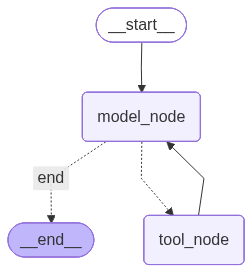

In [48]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import START,END
from langgraph.checkpoint.memory import MemorySaver

checkpointer= MemorySaver()

workflow = StateGraph(MyState)
workflow.add_node("model_node", function_1)
workflow.add_node("tool_node", ToolNode(tools=[tavily_search]))
workflow.add_conditional_edges("model_node", where_to_go,{
    "tool_node": "tool_node",
    "end": END
})

workflow.add_edge("tool_node", "model_node")
workflow.add_edge(START, "model_node")

graph= workflow.compile(checkpointer=checkpointer)
graph

In [49]:
config = {"configurable": {"thread_id": "2"}}


result= graph.invoke({
    'messages': [
       HumanMessage(content="Tell me about  Axa in 3 bullet points"),
    ]
},config=config)

result['messages'][-1].content

"- AXA is a global insurance and asset management company that operates in around 50 countries, serving approximately 95 million customers with offerings including property & casualty insurance, life insurance, savings solutions, and asset management.\n- The company's core purpose is to act for human progress by protecting individuals, businesses, and societies, emphasizing social responsibility through initiatives like climate change action and prevention efforts in risks.\n- AXA originated from a small mutual insurer in Normandy and has grown into a world leader in insurance, focusing on protection across personal property, liability, life insurance, health, savings, and retirement products for individual and business clients."

In [50]:
result= graph.invoke({
    'messages': [
       HumanMessage(content="What is his website"),
    ]
}, config=config)

result['messages'][-1].content

'The website for AXA is https://www.axa.com/'

In [51]:
config = {"configurable": {"thread_id": "1"}}

snapshot=graph.get_state(config=config)
snapshot

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [52]:
snapshot.values

{}